## Behavioral Econ/Finance -- Visualizing Opinion Dynamics




This simulation models the temporal evolution of probabilty density for a two-state opinion problem within a homogenous population of 2N, specifically looking at the Master Equation put forth by Weidlich & Haag (Concepts and Models of Quantitative Sociology -- Chapter 2). 

The plots at the end of this notebook show varitions of the evolution for different values of the adaptation parameter k (the probability of an individual actors' willingness to shift towards the majority opinion). Chapter 2 of Weidlich & Haag walks through the math behind the code, so I won't include too much detail in the explanation.

The generalized master equation:

$$ \large \frac{dp(i;t)}{dt} = \sum [w(i \leftarrow j) p(j; t) - w(j \leftarrow i) p (i; t) ]$$

This simulation uses the Euler approximation for discretization.

$$\large P(n;t+ \Delta t) =P(n;t) + \frac{dP(n;t)}{dt} \Delta t$$

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import special

In [10]:
def master_eq (num_entries, N, k0, delta_0, v = 1, k = 1, delta = 0):
    """
    Args:
    
        num_entries: # rows
        N: half the total population size
        k0: initial k value
        delta_0: initial delta value
        v: flexibility parameter -- the frequency with which opinion changes occur
        k: adaptation parameter -- indicates the tendency to conform to or reject the majority opinion
        delta: preference parameter -- (+) increases probability of switching from opinion 2 to opinion 1 and (-) increases the probability of switching from opinion 1 to opinion 2
            
    Returns: 
    
        A DF with values corresponding to time step (rows) and socio-configuration (cols) where the
        socio-configuration is the number of people holding a specific viewpoint. n = 0 means people are 
        evenly split between the two viewpoints.
    
    """
    n_arr = np.arange(-N,N+1)
    exp_arg = (2*delta_0*n_arr) + ((k0*n_arr**2)/N)
    pre_norm = scipy.special.comb(2*N, N+n_arr) * np.exp(exp_arg)
    
    normalizing_constant = 1/sum(pre_norm)
    
    w_up = pd.Series(v*(N-n_arr)*np.exp(delta+(k*n_arr)/N), n_arr)
    w_dn = pd.Series(v*(N+n_arr)*np.exp(-(delta+(k*n_arr)/N)), n_arr)
        
    def helper_dpdt(n, pbs):
        if n == N:
            res = (-w_dn[n]*pbs[n]) + (w_up[n-1]*pbs[n-1])
        elif n == -N:
            res = (w_dn[n+1]*pbs[n+1]) - (w_up[n]*pbs[n])
        else:
            res = ((w_dn[n+1]*pbs[n+1])-(w_dn[n]*pbs[n])) + ((w_up[n-1]*pbs[n-1])-(w_up[n]*pbs[n]))
        return res
    
    
    probs = pd.Series(pre_norm*normalizing_constant, n_arr)
    full_df = pd.DataFrame(probs)
    
    time = .01

    for _ in np.arange(num_entries):
        
        dps = []
        for i in n_arr:
            dps += [helper_dpdt(i, probs)]
        
        dps = pd.Series(dps, n_arr)
        entry = probs + (dps*.01)
        
        full_df[str(round(time,2))] = entry
        probs = entry
        time += .01
    
        
    return full_df.transpose()

In [11]:
t = master_eq(num_entries = 600, N = 25, k0 = .5, delta_0 = 0)
t.head()

-25           -24           -23           -22           -21  \
0     1.693292e-10  3.177557e-09  3.041043e-08  1.978234e-07  9.836083e-07   
0.01  2.211710e-10  4.055722e-09  3.797121e-08  2.419032e-07  1.179206e-06   
0.02  2.864120e-10  5.135172e-09  4.705917e-08  2.937710e-07  1.404765e-06   
0.03  3.678446e-10  6.451994e-09  5.790658e-08  3.544133e-07  1.663365e-06   
0.04  4.686899e-10  8.046730e-09  7.076775e-08  4.248830e-07  1.958215e-06   

           -20       -19       -18       -17       -16      ...       \
0     0.000004  0.000014  0.000041  0.000110  0.000265      ...        
0.01  0.000005  0.000016  0.000047  0.000123  0.000292      ...        
0.02  0.000005  0.000018  0.000053  0.000137  0.000321      ...        
0.03  0.000006  0.000021  0.000060  0.000152  0.000351      ...        
0.04  0.000007  0.000024  0.000067  0.000168  0.000383      ...        

            16        17        18        19        20            21  \
0     0.000265  0.000110  0.000041  0.000014  0.000004  9.836083e-07   
0.01  0.000292  0.000123  0.000047  0.000016  0.000005  1.179206e-06   
0.02  0.000321  0.000137  0.000053  0.000018  0.000005  1.404765e-06   
0.03  0.000351  0.000152  0.000060  0.000021  0.000006  1.663365e-06   
0.04  0.000383  0.000168  0.000067  0.000024  0.000007  1.958215e-06   

                22            23            24            25  
0     1.978234e-07  3.041043e-08  3.177557e-09  1.693292e-10  
0.01  2.419032e-07  3.797121e-08  4.055722e-09  2.211710e-10  
0.02  2.937710e-07  4.705917e-08  5.135172e-09  2.864120e-10  
0.03  3.544133e-07  5.790658e-08  6.451994e-09  3.678446e-10  
0.04  4.248830e-07  7.076775e-08  8.046730e-09  4.686899e-10  

[5 rows x 51 columns]

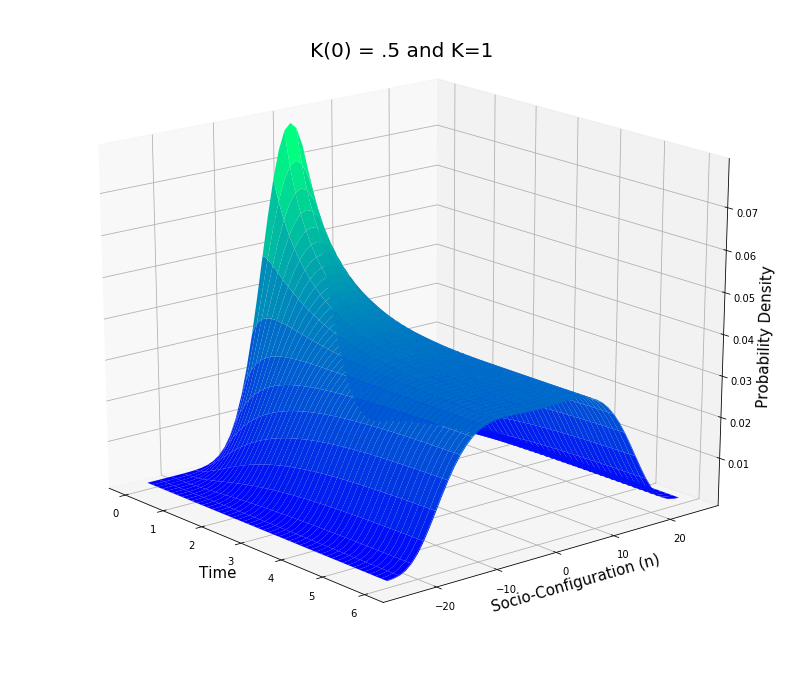

In [12]:
x = [float(i) for i in t.index.tolist()]
X,Y = np.meshgrid(x, t.columns)

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y, t.as_matrix().T, cmap = 'winter');
ax.view_init(elev = 20, azim = -40)
ax.set_xlabel('Time', fontsize = 15)
ax.set_ylabel('Socio-Configuration (n)', fontsize = 15)
ax.set_zlabel('Probability Density', fontsize = 15)
ax.set_title("K(0) = .5 and K=1", fontsize = 20);

In [13]:
test = master_eq(num_entries = 600, N = 25, k0 = 0, k = 1.3, delta_0 = 0)

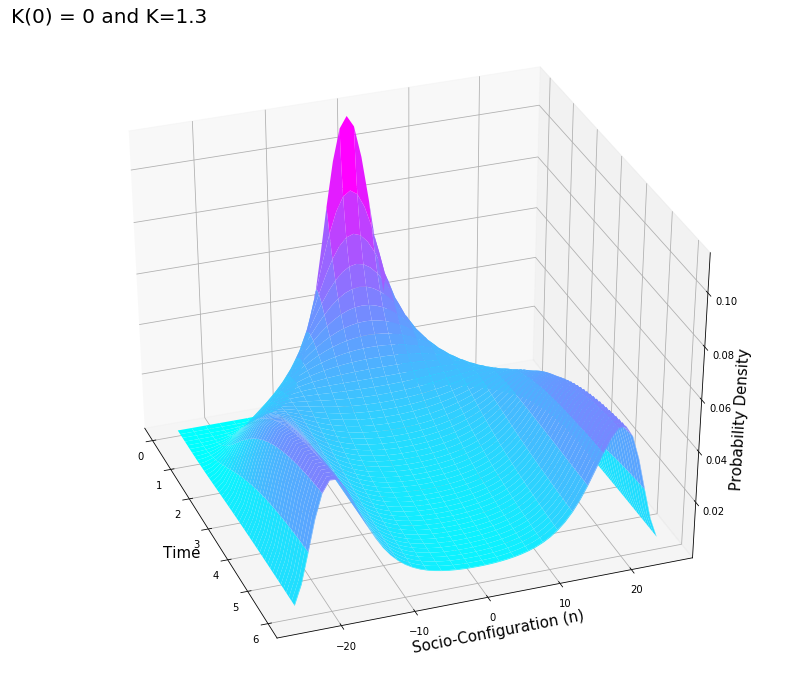

In [14]:
x = [float(i) for i in test.index.tolist()]
X,Y = np.meshgrid(x, test.columns)

fig1 = plt.figure(figsize=(14,12))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(X,Y, test.as_matrix().T, cmap = 'cool');
ax1.view_init(elev = 35, azim = -20)
ax1.set_xlabel('Time', fontsize = 15)
ax1.set_ylabel('Socio-Configuration (n)', fontsize = 15)
ax1.set_zlabel('Probability Density', fontsize = 15)
ax1.set_title("K(0) = 0 and K=1.3", fontsize = 20, loc = 'left');

In [15]:
test2 = master_eq(num_entries = 600, N = 25, k0 = 0, k=1.5, delta_0 = 0)

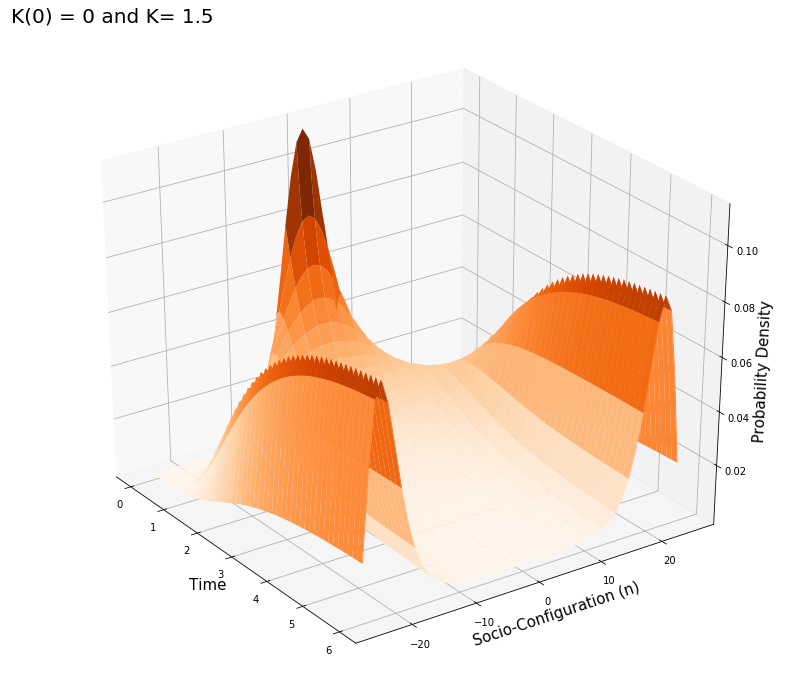

In [16]:
x = [float(i) for i in test2.index.tolist()]
X,Y = np.meshgrid(x, test2.columns)

fig2 = plt.figure(figsize=(14,12))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X,Y, test2.as_matrix().T, cmap = 'Oranges');
ax2.view_init(elev = 30, azim = -35)
ax2.set_xlabel('Time', fontsize = 15)
ax2.set_ylabel('Socio-Configuration (n)', fontsize = 15)
ax2.set_zlabel('Probability Density', fontsize = 15)
ax2.set_title("K(0) = 0 and K= 1.5", fontsize = 20, loc = 'left');